In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from torch.utils.data import DataLoader, random_split, TensorDataset
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
# Use GPU if available
device = torch.device('cuda:1' if torch.cuda.is_available else 'cpu')
print(f"Using device: {device}")

Using device: cuda:1


In [3]:
# Load RoBERTa tokenizer and model
model_name='distilbert/distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
# SwiGLU Activation Function
class SwiGLU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SwiGLU, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(input_dim, hidden_dim)
        self.gelu = nn.GELU()

    def forward(self, x):
        return self.gelu(self.linear1(x)) * self.linear2(x)

In [12]:
# Concept Classifier Model
class ConceptClassifier(nn.Module):
    def __init__(self, num_labels=2, model_name="roberta-base"):
        super(ConceptClassifier, self).__init__()
        self.model_name = model_name

        # Load RoBERTa model
        self.roberta = AutoModel.from_pretrained(model_name)
        hidden_size = self.roberta.config.hidden_size

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )

        # Additional layers
        self.norm = nn.LayerNorm(hidden_size)
        self.swiglu = SwiGLU(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, num_labels)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_ids, attention_mask=None, embeddings=None, labels=None, return_probs=True): # add a flag here for tokens vs embeddings
        
        if embeddings is not None:
            # Use pre-computed embeddings instead of RoBERTa outputs
            hidden_states = embeddings
        else:
            # Forward pass through RoBERTa
            outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state

        # Attention mechanism
        attention_weights = self.attention(hidden_states)  # Shape: [batch_size, seq_length, 1]
        weighted_output = torch.sum(attention_weights * hidden_states, dim=1)  # Shape: [batch_size, hidden_size]

        # Normalize and process through additional layers
        normalized_output = self.norm(weighted_output)
        x = self.swiglu(normalized_output)
        x = self.dropout(x)
        logits = self.fc2(x)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.fc2.out_features), labels.view(-1))

        # Return logits or probabilities based on the flag
        if return_probs:
            probs = F.softmax(logits, dim=-1)
            return (loss, probs) if loss is not None else probs
        else:
            return (loss, logits) if loss is not None else logits
            

In [13]:
# Load data from CSV
data_path = "imbalanced_concepts.csv"  # Replace with your CSV path
data = pd.read_csv(data_path)

# Define concept dictionary
concept_dict = dict()
for index, row in data.iterrows():
    if row['final_concept'] not in concept_dict:
        concept_dict[row['final_concept']]=list()
    if row['concept'] not in concept_dict[row['final_concept']]:
        concept_dict[row['final_concept']].append(row['concept'])
    
concept_dict

{'Service': ['service',
  'timing',
  'healthcare',
  'availability',
  'creditcards',
  'parking',
  'salesperson',
  'frequency',
  'transportation',
  'amenities',
  'work',
  'return',
  'traffic',
  'elevator',
  'surgery',
  'catering',
  'hours',
  'business',
  'staffing',
  'time',
  'punctuality',
  'internet',
  'management',
  'store',
  'menu',
  'care',
  'wifi',
  'capacity',
  'employment',
  'seating',
  'rentals',
  'website',
  'function',
  'delivery',
  'theft',
  'accessibility',
  'haircut',
  'staff',
  'option',
  'stylist',
  'choice',
  'system',
  'update',
  'maintenance',
  'hospital',
  'landscaping',
  'duration',
  'selection',
  'order',
  'dealership',
  'coverage',
  'truck',
  'grooming',
  'rental',
  'options',
  'facilities',
  'membership',
  'facility',
  'doctors',
  'banking',
  'waiting',
  'shop',
  'functionality',
  'water',
  'closure',
  'schedule',
  'insurance',
  'choices',
  'scheduling',
  'programs',
  'medical',
  'inventory',
  

In [14]:
# Tokenize and process data
def tokenize_data(reviews, labels):
    tokenized_data = tokenizer(reviews, padding=True, truncation=True, max_length=512, return_tensors="pt")
    input_ids = tokenized_data["input_ids"]
    attention_mask = tokenized_data["attention_mask"]
    label_ids = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(input_ids, attention_mask, label_ids)

In [15]:
# Map final concepts to indices
concept_labels = data['final_concept'].apply(lambda x: list(concept_dict.keys()).index(x)).tolist()
# print (concept_labels)

In [16]:
# Prepare datasets
dataset = tokenize_data(data['clean_text'].tolist(), concept_labels)
data_size = len(dataset)
train_size = int(0.7 * data_size)
val_size = int(0.15 * data_size)
test_size = data_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [17]:
# Model, loss, optimizer
model = ConceptClassifier(num_labels=len(concept_dict), model_name=model_name).to(device)

In [18]:
# Freeze the parameters of the RoBERTa backbone
for param in model.roberta.parameters():
    param.requires_grad = False

# Ensure all additional layers are trainable
for param in model.attention.parameters():
    param.requires_grad = True
for param in model.norm.parameters():
    param.requires_grad = True
for param in model.swiglu.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True
for param in model.dropout.parameters():
    param.requires_grad = True

# Optimizer for trainable parameters
trainable_params = [
    {'params': model.attention.parameters()},
    {'params': model.norm.parameters()},
    {'params': model.swiglu.parameters()},
    {'params': model.fc2.parameters()},
    {'params': model.dropout.parameters()}
]

optimizer = optim.AdamW(trainable_params, lr=0.0003)
criterion = nn.CrossEntropyLoss()

In [19]:
# Early stopping parameters
patience = 3
best_loss = float('inf')
best_model_state = None
wait = 0

# Lists for tracking loss
train_losses = []
val_losses = []

# Training loop
epochs = 50  # Maximum epochs
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Forward pass
        logits = model(input_ids, attention_mask=attention_mask, return_probs=False)
        loss = criterion(logits, labels)  

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            logits = model(input_ids, attention_mask=attention_mask, return_probs=False)
            loss = criterion(logits, labels)  

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# Save the best model
if best_model_state:
    model.load_state_dict(best_model_state)
torch.save(model.state_dict(), "concept_classifier.pt")
print("Model saved!")

Epoch 1/50 - Validation: 100%|██████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 83.72it/s]


Epoch 1/50, Train Loss: 0.4089, Val Loss: 0.3180


Epoch 2/50 - Validation: 100%|█████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 101.54it/s]


Epoch 2/50, Train Loss: 0.3196, Val Loss: 0.3091


Epoch 3/50 - Validation: 100%|█████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 220.61it/s]


Epoch 3/50, Train Loss: 0.2734, Val Loss: 0.3221


Epoch 4/50 - Validation: 100%|██████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 76.02it/s]


Epoch 4/50, Train Loss: 0.2194, Val Loss: 0.2965


Epoch 5/50 - Validation: 100%|██████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 79.06it/s]


Epoch 5/50, Train Loss: 0.1814, Val Loss: 0.2960


Epoch 6/50 - Validation: 100%|██████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 83.02it/s]


Epoch 6/50, Train Loss: 0.1389, Val Loss: 0.3229


Epoch 7/50 - Validation: 100%|█████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 130.51it/s]


Epoch 7/50, Train Loss: 0.1017, Val Loss: 0.3677


Epoch 8/50 - Validation: 100%|█████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 220.62it/s]


Epoch 8/50, Train Loss: 0.0763, Val Loss: 0.4286
Early stopping triggered.
Model saved!


In [20]:
# Evaluate on test set
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating Test Set"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Forward
        probs = model(input_ids, attention_mask=attention_mask)

        # Predictions
        preds = torch.argmax(probs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        all_probs.extend(probs.cpu().numpy())  # Store probabilities if needed
        all_preds.extend(preds)
        all_labels.extend(labels)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

Evaluating Test Set: 100%|██████████████████████████████████████████████████████████████| 55/55 [00:00<00:00, 79.92it/s]

Test Accuracy: 0.8486
Test Precision: 0.8488
Test Recall: 0.8486
Test F1 Score: 0.8454


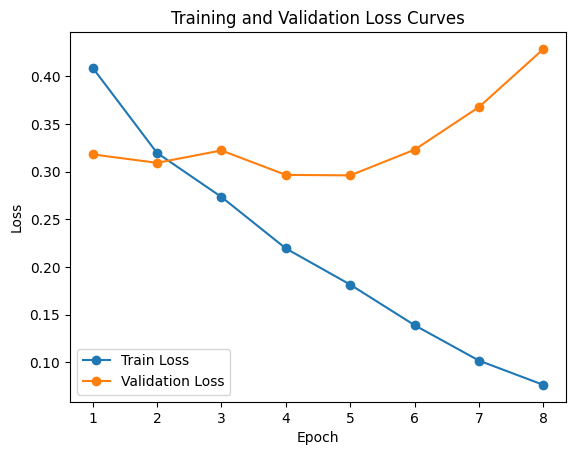

In [21]:
# Plot the loss curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()